# Review Data Analysis

Paper: Do Resilience Metrics of Water Distribution Systems Really Assess Resilience? A Critical Review

Authors:
- Michaela Leštáková, orcid: 0000-0002-5998-6754 (Corresponding author: michaela.lestakova@fst.tu-darmstadt.de)
- Kevin T. Logan, orcid: 0000-0001-5512-2679
- Imke Rehm, orcid: 0000-0001-9751-3934
- John Friesen, orcid: 0000-0003-2530-1363
- Peter F. Pelz, orcid: 0000-0002-0195-627X

This Jupyter Notebook contains the code for the analysis of data gathered for the paper specified above.


In [82]:
import itertools
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sankeyflow import Sankey

from scipy.cluster.hierarchy import (
    fcluster,
    linkage,
    dendrogram,
    set_link_color_palette,
)

from tools import delete_linebreak, add_citation, perc


In [83]:
# Select whether you want to run the analysis for internal purposes (for authors;
# the figures will include Latex references which will not compile properly in the Jupyter notebook)
# or external purposes (for readers; will NOT include Latex references)

external = True


In [84]:
df = pd.read_excel(
    "https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/3900/WDS_resilience_metrics_review_paper.xlsx",
    header=1
)
df.head()


authors  \
0  Pelz, Peter F.; Groche, Peter; Pfetsch, Marc E...   
1  Pelz, Peter F.; Groche, Peter; Pfetsch, Marc E...   
2  Hashimoto, Tsuyoshi; Stedinger, Jery; Loucks, ...   
3                                       Todini, Ezio   
4  Altherr, Lena C.; Brötz, Nicolas; Dietrich, In...   

                                               title  \
0    Mastering Uncertainty in Mechanical Engineering   
1    Mastering Uncertainty in Mechanical Engineering   
2  Reliability, Resiliency and Vulnerability Crit...   
3  Looped water distribution networks design usin...   
4  Resilience in Mechanical Engineering – A Conce...   

                                      DOI source  year  \
0               10.1007/978-3-030-78354-9  other  2021   
1               10.1007/978-3-030-78354-9  other  2021   
2                 10.1029/WR018i001p00014  other  1983   
3           10.1016/S1462-0758(00)00049-2  other  2000   
4  10.4028/www.scientific.net/AMM.885.187  other  2018   

                   name of metric  monitor  react  learn  anticipate  ...  \
0            graceful degradation        0      1      0           0  ...   
1            rapidity of recovery        0      1      0           0  ...   
2  system's average recovery rate        0      1      0           0  ...   
3                resilience index        0      0      0           1  ...   
4              buffering capacity        0      0      0           1  ...   

   recovery  optimal value                  interval  \
0         0            1.0  [0, infinity], 0 is best   
1         1            1.0  [0, infinity], 0 is best   
2         1            1.0                     [0,1]   
3         0            1.0                     [0,1]   
4         0            0.0                       NaN   

                       critical event  comparability  \
0                         independent              0   
1                         independent              0   
2  change in demand; change in supply              0   
3      change in demand; pipe failure              1   
4               any component failure              0   

                           Derived from   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4  https://doi.org/10.1201/9781315605685   

                                         studied WDS  \
0                                               none   
1                                               none   
2                                               none   
3  none, none, https://doi.org/10.1029/WR013i006p...   
4                                               none   

                               studied WDS - comment  cluster         citation  
0                                                NaN        2       Pelz.2021b  
1                                                NaN        1       Pelz.2021b  
2                                                NaN        1   Hashimoto.1982  
3  1. extremely simplified two-loop network from ...        3  EzioTodini.2000  
4                                                NaN        3     Altherr.2018  

[5 rows x 28 columns]

## RQ1: How do existing metrics assess resilience? 

In [85]:
metrics_by_type = ["graph-theoretical", "score-based", "performance-based"]
metrics_by_time = ["time-independent", "time-dependent"]


### Metrics according to their quantitative measure type

In [86]:
for mt in metrics_by_type:
    print(
        "{} ({}%) metrics are {}".format(
            len(df.loc[df[mt] == 1]), perc(len(df.loc[df[mt] == 1]), len(df)), mt
        )
    )


9 (15.25%) metrics are graph-theoretical
4 (6.78%) metrics are score-based
46 (77.97%) metrics are performance-based


### Metrics according to their dependence on time

In [87]:
for p in metrics_by_time:
    print(
        "{} ({}%) metrics assess {} resilience".format(
            len(df.loc[df[p] == 1]), perc(len(df.loc[df[p] == 1]), len(df)), p
        )
    )


34 (57.63%) metrics assess time-independent resilience
25 (42.37%) metrics assess time-dependent resilience


In [88]:
nodes = [
    [("composite", len(df.loc[(df["composite"] == 1)]))],
    [
        ("graph-theoretical", len(df.loc[(df["graph-theoretical"] == 1)])),
        ("score-based", len(df.loc[(df["score-based"] == 1)])),
        ("performance-based", len(df.loc[(df["performance-based"] == 1)])),
    ],
    [
        ("time-independent", len(df.loc[(df["time-independent"] == 1)])),
        ("time-dependent", len(df.loc[(df["time-dependent"] == 1)])),
    ],
]


flows = []

for s, t in itertools.product(metrics_by_type, metrics_by_time):
    flow = []
    flow.append(s)
    flow.append(t)
    flow.append(len(df.loc[(df[s] == 1) & (df[t] == 1)]))
    flows.append(flow)

for s, t in itertools.product(["composite"], metrics_by_type):
    flow = []
    flow.append(s)
    flow.append(t)
    flow.append(len(df.loc[(df[s] == 1) & (df[t] == 1)]))
    flows.append(flow)

s = Sankey(
    flows=flows,
    nodes=nodes,
    cmap=plt.cm.Pastel1,
    flow_color_mode="source",
    align_y="top",
)
s.draw()
plt.savefig("figures/metrics_type.pdf")


### Comparability 

In [89]:
n_comparability = len(df.loc[df["comparability"] == 1])
print(
    "{} ({}%) metrics include comparability".format(
        n_comparability, perc(n_comparability, len(df))
    )
)


12 (20.34%) metrics include comparability


In [90]:
"{} metric have an optimal value.".format(len(df.loc[df["optimal value"] == 1].index))


'36 metric have an optimal value.'

In [91]:
print("Intervals present:")
df["interval"].value_counts()


Intervals present:


[0,1]                                                   13
1                                                        6
[0, infinity], 0 is best                                 2
0-100%                                                   1
0, inf; 0 is best                                        1
[1,5]                                                    1
service deficit = 0, service management capacity = 1     1
[1,10]                                                   1
minimize is best: min=0                                  1
0 is the best                                            1
Name: interval, dtype: int64

## RQ2: To what extent do the existing metrics assess resilience using the four resilience sub-functions? 


### Metrics by functions assessed

In [92]:
r_functions = ["anticipate", "monitor", "react", "learn"]
for rf in r_functions:
    print(
        "{} ({}%) metrics assess {}".format(
            len(df.loc[df[rf] == 1]), perc(len(df.loc[df[rf] == 1]), len(df)), rf
        )
    )


34 (57.63%) metrics assess anticipate
1 (1.69%) metrics assess monitor
26 (44.07%) metrics assess react
1 (1.69%) metrics assess learn


In [93]:
rf_sum = df[r_functions].sum(axis=1)

for i in range(1, 5):
    print(
        "{} ({}%) metrics assess {} functions.".format(
            len(rf_sum.loc[rf_sum == i]), perc(len(rf_sum.loc[rf_sum == i]), len(df)), i
        )
    )


57 (96.61%) metrics assess 1 functions.
1 (1.69%) metrics assess 2 functions.
1 (1.69%) metrics assess 3 functions.
0 (0.0%) metrics assess 4 functions.


### Metrics by properties assessed

In [94]:
r_properties = ["baseline functionality", "redundancy", "recovery"]
for rp in r_properties:
    print(
        "{} ({}%) metrics consider {}".format(
            len(df.loc[df[rp] == 1]), perc(len(df.loc[df[rp] == 1]), len(df)), rp
        )
    )


20 (33.9%) metrics consider baseline functionality
18 (30.51%) metrics consider redundancy
21 (35.59%) metrics consider recovery


In [95]:
rp_sum = df[r_properties].sum(axis=1)

for i in range(1, 4):
    print(
        "{} ({}%) metrics consider {} properties.".format(
            len(rp_sum.loc[rp_sum == i]), perc(len(rp_sum.loc[rp_sum == i]), len(df)), i
        )
    )


27 (45.76%) metrics consider 1 properties.
13 (22.03%) metrics consider 2 properties.
2 (3.39%) metrics consider 3 properties.


In [96]:
fig, axs = plt.subplots(2, 2, sharey=True)

axs[0, 0].bar(
    [rf[0].capitalize() for rf in r_functions],
    [len(df.loc[df[rf] == 1]) for rf in r_functions],
)
axs[0, 0].set_ylabel("NR. METRICS")
axs[0, 0].set_xlabel("FUNCTIONS ADDRESSED")

axs[0, 1].bar(np.arange(1, 5), [len(rf_sum.loc[rf_sum == i]) for i in np.arange(1, 5)])
axs[0, 1].set_xticks(np.arange(1, 5))
# axs[0, 1].set_ylabel('NR. OF METRICS')
axs[0, 1].set_xlabel("NR. FUNCTIONS ADDRESSED")

axs[1, 0].bar(["BF", "RD", "RC"], [len(df.loc[df[rp] == 1]) for rp in r_properties])
axs[1, 0].set_ylabel("NR. METRICS")
axs[1, 0].set_xlabel("PROPERTIES ADDRESSED")

axs[1, 1].bar(np.arange(1, 4), [len(rp_sum.loc[rp_sum == i]) for i in np.arange(1, 4)])
axs[1, 1].set_xticks(np.arange(1, 4))
# axs[1, 1].set_ylabel('NR. OF METRICS')
axs[1, 1].set_xlabel("NR. PROPERTIES ADDRESSED")

fig.tight_layout()
fig.savefig("figures/metrics_by_functions.pgf", format="pgf", bbox_inches="tight")
fig.savefig("figures/metrics_by_functions.svg", format="svg", bbox_inches="tight")
fig.savefig("figures/metrics_by_functions.pdf", bbox_inches="tight")


## RQ3: How general are the existing resilience metrics with regard to different critical events? 


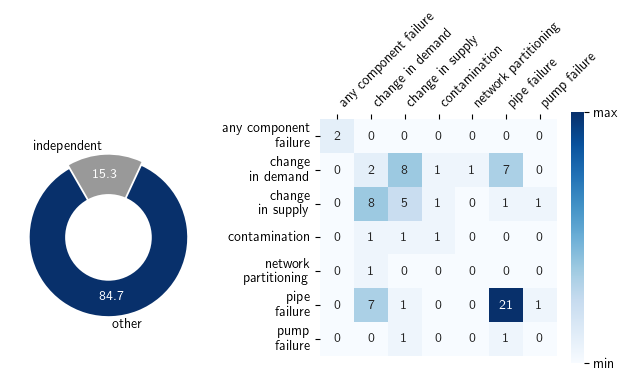

In [97]:
scenario_df = df["critical event"].str.get_dummies(sep="; ")
hm_df = pd.DataFrame(columns=scenario_df.columns, index=scenario_df.columns)

for x, y in itertools.product(scenario_df.columns, repeat=2):
    if x == y:
        # if index is the same, count only the rows where the critical event is the only failure 
        # (not in connection with other critical events)
        hm_df.loc[x][y] = float(
            len(scenario_df.loc[(scenario_df.loc[:, scenario_df.columns!=x].sum(axis=1) == 0)])
        )
    else:
        hm_df.loc[x][y] = float(
            len(scenario_df.loc[(scenario_df[x] == 1) & (scenario_df[y] == 1)])
        )

hm_df = hm_df[hm_df.columns].astype(float)  # or int

# Plots
fig, axs = plt.subplots(ncols=2, width_ratios=[1, 1.5])

# pie chart
scenario_overview = {
    "other": len(df.loc[df["critical event"] != "independent"]),
    "independent": len(df.loc[df["critical event"] == "independent"]),
}
cmap = matplotlib.colormaps["Blues"]
pie_color = cmap(0.999)
patches, texts, autotexts = axs[0].pie(
    scenario_overview.values(),
    labels=scenario_overview.keys(),
    colors=[
        pie_color,
        "#999999",
    ],
    autopct="%1.1f%%",
    startangle=120,
    pctdistance=0.75,
    explode=(0.0, 0.05),
)
[autotext.set_color("#FFFFFF") for autotext in autotexts]
[autotext.set_fontsize(10) for autotext in autotexts]
# add circle to have a donut plot
axs[0].add_patch(plt.Circle((0, 0), 0.55, fc="#FFFFFF"))

# heatmap plot
sns.heatmap(
    hm_df.drop("independent", axis=0).drop("independent", axis=1),
    cmap="Blues",
    cbar_kws={"shrink": 0.6},
    annot=True,
    annot_kws={"size": 10},
    ax=axs[1],
    square=True,
)
axs[1].xaxis.tick_top()  # x axis on top
axs[1].xaxis.set_label_position("top")
y_labels = []
# split label strings on two lines
for a in hm_df.drop("independent", axis=1).columns:
    s_list = a.split(" ")
    if len(s_list) > 1:
        if "in" in s_list:
            s_list.insert(-2, "\n")
        else:
            s_list.insert(-1, "\n")
        a = " ".join(s_list)
    y_labels.append(a)
# adjust tick labels position, rotation and size
axs[1].set_yticklabels(y_labels)
for label in axs[1].get_xticklabels():
    label.set_rotation(45)
    label.set_ha("left")
    label.set_fontsize(10)
    label.set_color("k")
for label in axs[1].get_yticklabels():
    label.set_fontsize(10)
    label.set_horizontalalignment("right")
    label.set_color("k")
axs[1].collections[0].colorbar.ax.tick_params(labelsize=10)
axs[1].collections[0].colorbar.ax.set_yticks([0, 21])
axs[1].collections[0].colorbar.ax.set_yticklabels(["min", "max"])

# fig = axs[1].get_figure()

fig.tight_layout()
fig.savefig("figures/heatmap_scenarios.pgf", format="pgf", bbox_inches="tight")
fig.savefig("figures/heatmap_scenarios.svg", format="svg", bbox_inches="tight", transparent=True)
fig.savefig("figures/heatmap_scenarios.pdf", bbox_inches="tight")


## Clustering

In [98]:
# Perform clustering
# Source: https://predictivehacks.com/hierarchical-clustering-in-python/

plt.rcParams.update(
    {
        "font.family": "sans-serif",  # use serif/main font for text elements
        "font.sans-serif": "Verdana",
        "text.usetex": True,  # use inline math for ticks
        "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    }
)

df_c = deepcopy(
    df[
        [
            "name of metric",
            "citation",
            "monitor",
            "react",
            "learn",
            "anticipate",
            "time-independent",
            "time-dependent",
            "graph-theoretical",
            "performance-based",
            "score-based",
            "composite",
            "baseline functionality",
            "redundancy",
            "recovery",
        ]
    ]
)


df_c.replace("", 0, inplace=True)

df_c["name of metric"] = df_c["name of metric"].apply(delete_linebreak)
if external is False:
    df_c["name of metric"] = df_c.apply(
        add_citation, metric_row_name="name of metric", axis=1
    )

df_c.set_index(df_c["name of metric"], inplace=True)

df_c.drop(columns=["name of metric", "citation"], inplace=True)
# Use the linkage() function
distance_matrix = linkage(df_c, method="ward", metric="euclidean")


In [99]:
# Visualise clusters
fig = plt.figure(figsize=(5, 6))
ax = fig.add_subplot()

# Set colors
set_link_color_palette(["#fdca00", "#ee7a34", "#50b695", "#004e73", "#000000ff"])

# Create a dendrogram
dn = dendrogram(
    distance_matrix,
    p=300,
    ax=ax,
    truncate_mode="level",
    show_leaf_counts=True,
    orientation="right",
    labels=df_c.index.tolist(),
    color_threshold=3.135,
    above_threshold_color="lightgrey",
)
# Style plot
# hide axes, axis labels, ticks
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.spines["left"].set_visible(False)

# CL5 is hardcoded here for the purpose of better visualisation
ax.hlines(75, 0, 3.1, color="#333333")

# add legend
legend_elements = [
    Line2D([0], [0], color="#ee7a34", lw=2, label="CL1"),
    Line2D([0], [0], color="#fdca00", lw=2, label="CL2"),
    Line2D([0], [0], color="#004e73", lw=2, label="CL3"),
    Line2D([0], [0], color="#50b695", lw=2, label="CL4"),
    Line2D([0], [0], color="#333333", lw=2, label="CL5"),
]
ax.legend(
    handles=legend_elements,
    frameon=False,
    # loc='center'
)

# Display the dendogram
plt.tight_layout()
plt.savefig("figures/dendrogram.pgf", format="pgf", bbox_inches="tight")
plt.savefig("figures/dendrogram.svg", format="svg", bbox_inches="tight")
plt.savefig("figures/dendrogram.pdf", bbox_inches="tight")
plt.show()

# Assign cluster labels
df_cl = pd.DataFrame()


In [100]:
df_c["cluster_labels"] = fcluster(distance_matrix, 5, criterion="maxclust")

df_c.loc[df_c["cluster_labels"] == 2]


monitor  react  learn  \
name of metric                                                           
rapidity of recovery                                   0      1      0   
system's average recovery rate                         0      1      0   
integral waterservice availability                     0      1      0   
recovery rate                                          0      1      0   
global resilience index                                0      1      0   
Flow-Based Resilience Metric                           0      1      0   
serviceability index SI                                0      1      0   
resilience factor                                      0      1      0   
Dynamic Infrastructure System Resilience Metric        0      1      0   
total resilience                                       0      1      0   
coupled service deficit and service management         0      1      0   
weighted resilience metric                             0      1      0   
Resilience Measure                                     0      1      0   
Seismic Resilience Index                               0      1      0   
Asset-based resilience                                 0      1      0   
Fuzzy resilience index                                 0      1      0   
mean time to repair                                    0      1      0   
measure of performance (MOP)                           0      1      0   

                                                 anticipate  time-independent  \
name of metric                                                                  
rapidity of recovery                                      0                 0   
system's average recovery rate                            0                 0   
integral waterservice availability                        0                 0   
recovery rate                                             0                 0   
global resilience index                                   0                 0   
Flow-Based Resilience Metric                              0                 0   
serviceability index SI                                   0                 0   
resilience factor                                         0                 0   
Dynamic Infrastructure System Resilience Metric           0                 0   
total resilience                                          0                 0   
coupled service deficit and service management            0                 0   
weighted resilience metric                                0                 0   
Resilience Measure                                        0                 0   
Seismic Resilience Index                                  0                 0   
Asset-based resilience                                    0                 0   
Fuzzy resilience index                                    0                 0   
mean time to repair                                       0                 0   
measure of performance (MOP)                              0                 0   

                                                 time-dependent  \
name of metric                                                    
rapidity of recovery                                          1   
system's average recovery rate                                1   
integral waterservice availability                            1   
recovery rate                                                 1   
global resilience index                                       1   
Flow-Based Resilience Metric                                  1   
serviceability index SI                                       1   
resilience factor                                             1   
Dynamic Infrastructure System Resilience Metric               1   
total resilience                                              1   
coupled service deficit and service management                1   
weighted resilience metric                                    1   
Resilienc

## Correlation

In [101]:
df_p = df_c.drop(columns=["cluster_labels"]).corr("pearson")
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    df_p.round(2),
    annot=True,
    cmap=sns.diverging_palette(18, 240, s=100, l=30, as_cmap=True),
    ax=ax,
    annot_kws={"size": 10},
    square=True,
)

ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
# plt.xticks(rotation=45)
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha("left")
    label.set_fontsize(12)
for label in ax.get_yticklabels():
    label.set_fontsize(12)
plt.tight_layout()
plt.savefig("figures/correlation.pgf", format="pgf", bbox_inches="tight")
plt.savefig("figures/correlation.svg", format="svg", bbox_inches="tight")
plt.savefig("figures/correlation.pdf", bbox_inches="tight")
plt.show()

f = open("figures/correlation.pgf", "r")
filedata = f.read()
f.close()

newdata = filedata.replace("correlation-img0.png", "figures/correlation-img0.png")

f = open("figures/correlation.pgf", "w")
f.write(newdata)
f.close()
